In [79]:
import numpy as np
import random
import scipy.stats
import math

import thinkstats2
import thinkplot
from normal import Normal
import first
import hypothesis

In [56]:
thinkstats2.EvalNormalCdfInverse(0.05, mu=90, sigma=2.5)

85.88786593262132

In [57]:
thinkstats2.EvalNormalCdfInverse(0.95, mu=90, sigma=2.5)

94.11213406737868

In [58]:
dist = Normal(90, 7.5**2)
dist

Normal(90, 56.25)

In [59]:
dist_xbar = dist.Sum(9) / 9
dist_xbar.sigma

2.5

In [60]:
dist_xbar.Percentile(5), dist_xbar.Percentile(95)

(85.88786593262132, 94.11213406737868)

In [61]:
def MakeExpoSamples(beta=2.0, iters=1000):
    samples = []
    for n in [1, 10, 100]:
        sample = [np.sum(np.random.exponential(beta, n)) for _ in range(iters)]
        samples.append((n, sample))
    return samples

In [62]:
def NormalPlotSamples(samples, plot=1, ylabel=''):
    for n, sample in samples:
        thinkplot.SubPlot(plot)
        thinkstats2.NormalProbabilityPlot(sample)
        
        thinkplot.Config(title='n=%d' % n, ylabel=ylabel)
        plot += 1

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


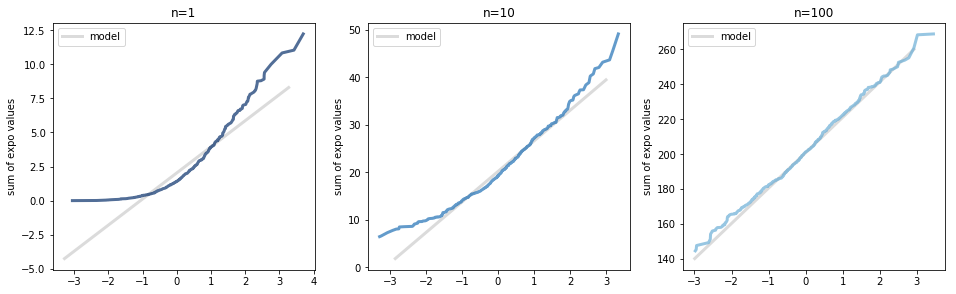

In [63]:
thinkplot.PrePlot(num=3, rows=2, cols=3)
samples = MakeExpoSamples()
NormalPlotSamples(samples, plot=1, ylabel='sum of expo values')

In [64]:
def MakeLognormalSamples(mu=1.0, sigma=1.0, iters=1000):
    samples = []
    for n in [1, 10, 100]:
        sample = [np.sum(np.random.lognormal(mu, sigma, n)) for _ in range(iters)]
        samples.append((n, sample))
    return samples

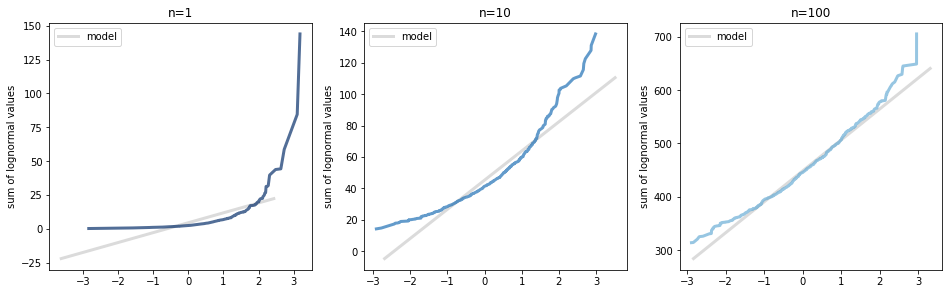

In [65]:
thinkplot.PrePlot(num=3, rows=2, cols=3)
samples = MakeLognormalSamples()
NormalPlotSamples(samples, ylabel='sum of lognormal values')

In [66]:
def MakeParetoSamples(alpha=1.0, iters=1000):
    samples = []
    for n in [1, 10, 100]:
        sample = [np.sum(np.random.pareto(alpha, n)) for _ in range(iters)]
        samples.append((n, sample))
        
    return samples

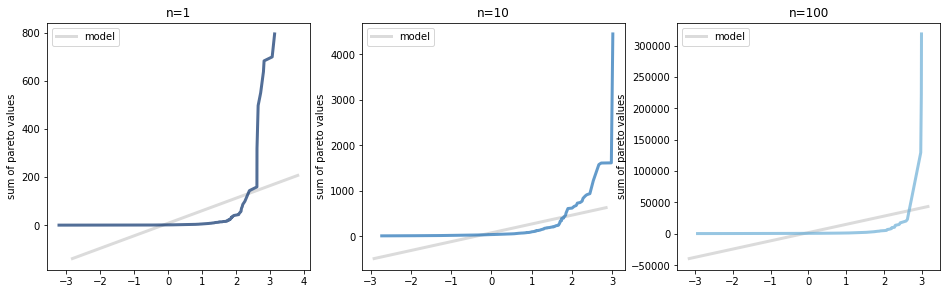

In [67]:
thinkplot.PrePlot(num=3, rows=2, cols=3)
samples = MakeParetoSamples()
NormalPlotSamples(samples, ylabel = 'sum of pareto values')

In [68]:
def GenerateCorrelated(rho, n):
    x = random.gauss(0, 1)
    yield x
    
    sigma = math.sqrt(1 - rho**2)
    for _ in range(n-1):
        x = random.gauss(x*rho, sigma)
        yield x

In [69]:
def GenerateExpoCorrelated(rho, n):
    normal = list(GenerateCorrelated(rho, n))
    uniform = scipy.stats.norm.cdf(normal)
    expo = scipy.stats.expon.ppf(uniform)
    return expo

In [70]:
def MakeCorrelatedSamples(rho=0.9, iters=1000):
    samples = []
    for n in [1, 10, 100]:
        sample = [np.sum(GenerateExpoCorrelated(rho, n)) for _ in range(iters)]
        samples.append((n, sample))
    return samples

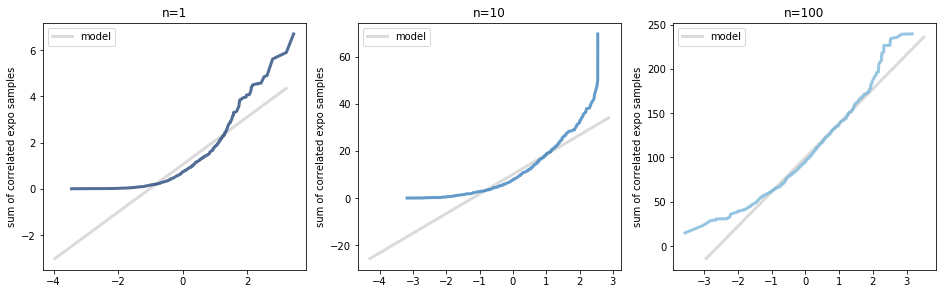

In [71]:
thinkplot.PrePlot(num=3, rows=2, cols=3)
samples = MakeCorrelatedSamples()
NormalPlotSamples(samples, ylabel='sum of correlated expo samples')

In [72]:
live, firsts, others = first.MakeFrames()
delta = firsts.prglngth.mean() - others.prglngth.mean()
delta

0.07803726677754952

In [73]:
def SamplingDistMean(data, n):
    mean, var = data.mean(), data.var()
    dist = Normal(mean, var)
    return dist.Sum(n) / n

In [74]:
dist1 = SamplingDistMean(live.prglngth, len(firsts))
dist2 = SamplingDistMean(live.prglngth, len(others))
dist1, dist2

(Normal(38.5606, 0.00165481), Normal(38.5606, 0.00154227))

In [75]:
dist = dist1 - dist2
dist

Normal(0, 0.00319708)

In [76]:
1 - dist.Prob(delta)

0.08377070425543831

In [77]:
dist.Prob(-delta)

0.08377070425543826

In [78]:
def StudentCdf(n):
    ts = np.linspace(-3, 3, 101)
    ps = scipy.stats.t.cdf(ts, df=n-2)
    rs = ts / np.sqrt(n - 2 + ts**2)
    return thinkstats2.Cdf(rs, ps)

In [80]:
class CorrelationPermute(hypothesis.CorrelationPermute):
    def TestStatistic(self, data):
        xs, ys = data
        return np. corrcoef(xs, ys)[0][1]

In [81]:
def ResampleCorrelations(live):
    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = CorrelationPermute(data)
    p_value = ht.PValue()
    return len(live2), ht.actual, ht.test_cdf

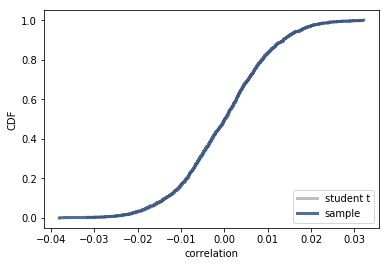

In [82]:
n, r, cdf = ResampleCorrelations(live)

model = StudentCdf(n)
thinkplot.Plot(model.xs, model.ps, color='gray', alpha=0.5, label='student t')
thinkplot.Cdf(cdf, label='sample')
thinkplot.Config(xlabel='correlation', ylabel='CDF', legend=True, loc='lower right')

In [85]:
t = r * np.sqrt((n-2) / (1 - r**2))
p_value = 1 - scipy.stats.t.cdf(t, df=n-2)
print(r, p_value)

0.0688339703541091 2.861466619208386e-11


In [86]:
def ChiSquaredCdf(n):
    xs = np.linspace(0, 25, 101)
    ps = scipy.stats.chi2.cdf(xs, df=n-1)
    return thinkstats2.Cdf(xs, ps)

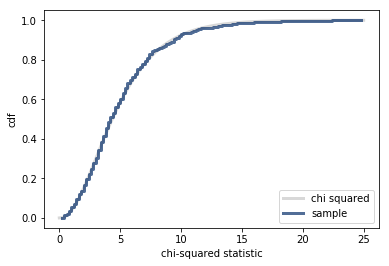

In [88]:
data = [8, 9, 19, 5, 8, 11]
dt = hypothesis.DiceChiTest(data)
p_value = dt.PValue(iters=1000)
n, chi2, cdf = len(data), dt.actual, dt.test_cdf

model = ChiSquaredCdf(n)
thinkplot.Plot(model.xs, model.ps, color='gray', alpha=0.3, label='chi squared')
thinkplot.Cdf(cdf, label='sample')
thinkplot.Config(xlabel='chi-squared statistic', ylabel='cdf', loc='lower right')

In [90]:
p_value = 1 - scipy.stats.chi2.cdf(chi2, df=n-1)
chi2, p_value

(11.6, 0.04069938850404997)